In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Jan  6 06:50:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Instal apex if you want to do 16 bit training. You'll probably need to restart the notebook after installing apex

In [ ]:
# !export CUDA_HOME=/usr/local/cuda-10.1
# !git clone https://github.com/NVIDIA/apex
# !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [3]:
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5

     |████████████████████████████████| 645kB 15.1MB/s 
     |████████████████████████████████| 1.1MB 31.6MB/s 
     |████████████████████████████████| 890kB 67.9MB/s 
     |████████████████████████████████| 3.8MB 56.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=ad5e96229e6c1ea7d73029ab25657729dc11462b3e794c1fe2db4ea9f5990aa6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 235kB 12.2MB/s 
     |████████████████████████████████| 829kB 26.0MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=4b84adea82d94311cf913d6c879abc8a45b4e2b03e8b70de1e1e6b12f00cddc7
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
   

## T5 fine-tuning

This notebook is to showcase how to fine-tune [T5 model](https://arxiv.org/abs/1910.10683) with Huggigface's [Transformers](https://github.com/huggingface/transformers/) to solve different NLP tasks using text-2-text approach proposed in the T5 paper. For demo I chose 3 non text-2-text problems just to reiterate the fact from the paper that how widely applicable this text-2-text framework is and how it can be used for different tasks without changing the model at all.

This is a rough draft so if you find any issues with this notebook or have any  questions reach out to me via [Twitter](https://twitter.com/psuraj28).



In [78]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [79]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

## Model

We'll be using the awesome [pytorch-lightning](https://github.com/PytorchLightning/pytorch-lightning) library for training. Most of the below code is adapted from here https://github.com/huggingface/transformers/blob/master/examples/lightning_base.py

The trainer is generic and can be used for any text-2-text task. You'll just need to change the dataset. Rest of the code will stay unchanged for all the tasks.

This is the most intresting and powrfull thing about the text-2-text format. You can fine-tune the model on variety of NLP tasks by just formulating the problem in text-2-text setting. No need to change hyperparameters, learning rate, optimizer or loss function. Just plug in your dataset and you are ready to go!

In [80]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [81]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

Let's define the hyperparameters and other arguments. You can overide this `dict` for specific task as needed. While in most of cases you'll only need to change the `data_dir`and `output_dir`.

Here the batch size is 8 and gradient_accumulation_steps are 16 so the effective batch size is 128

In [82]:
args_dict = dict(
    data_dir="", # path for data files
    output_dir="", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

## Emotion classification

While most of the sentiment-analysis datasets are binary with 'postive' and 'negative' sentiments, [Elvis Saravia](https://twitter.com/omarsar0)  has put together a great [dataset](https://github.com/dair-ai/emotion_dataset) for emotion recognition. The task is given some text classifiy the text into one of the following six emotions 

'sadness', 'joy', 'anger', 'fear', 'surprise', 'love'.

Here's the [original notebook](https://colab.research.google.com/drive/1nwCE6b9PXIKhv2hvbqf1oZKIGkXMTi1X#scrollTo=pSzoz9InH0Ta) which trains ROBERTa model to classify the text

### Download and view data

In [ ]:
#!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
#!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
#!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

In [9]:
!mkdir emotion_data
#!mv *.txt emotion_data

In [83]:
train_path = "emotion_data/train1.txt"
test_path = "emotion_data/test.txt"
val_path = "emotion_data/val.txt"

## emotion labels
label2int = {
  "irritated": 0,
  "disappointed": 1,
  "neutral": 2,
  "happy": 3,
  "delighted": 4
}

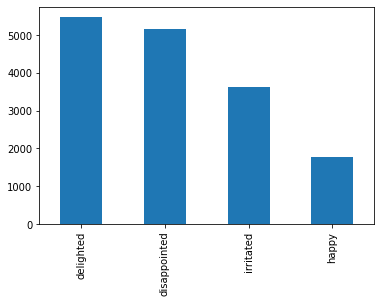

In [84]:
data = pd.read_csv(train_path, sep=";", header=None, names=['text', 'emotion'],
                               engine="python")
data.emotion.value_counts().plot.bar()

In [85]:
data.head()

,text,emotion
0,neutral didnt feel humiliated,disappointed
1,i can go from feeling so hopeless to so damned...,disappointed
2,im grabbing a minute to post i feel greedy wrong,disappointed
3,i am ever feeling nostalgic about the fireplac...,delighted
4,i am feeling grouchy,disappointed


In [86]:
data.count()

text       16000
emotion    16000
dtype: int64

In [87]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/t5-spiece.model from cache at /root/.cache/torch/transformers/68f1b8dbca4350743bb54b8c4169fd38cbabaad564f85a9239337a8d0342af9f.9995af32582a1a7062cb3173c118cb7b4636fa03feb967340f20fc37406f021f


### Dataset

Here also we will process the examples in the same way we did above. If the label is 'love' we will ask the model to predict the text 'love'

Lets check how t5 encodes the following labels

In [88]:
emotions = [ "irritated", "disappointed", "neutral", "happy", "delighted"]
for em in emotions:
  print(len(tokenizer.encode(em)))

4
1
1
1
1


Here also all the labels are encoded as single ids

In [89]:
class EmotionDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.path = os.path.join(data_dir, type_path + '.txt')

    self.data_column = "text"
    self.class_column = "emotion"
    self.data = pd.read_csv(self.path, sep=";", header=None, names=[self.data_column, self.class_column],
                            engine="python")
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data)):
      input_, target = self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]      
      
      input_ = input_ + ' </s>'
      target = target + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [90]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
len(dataset)

1004

In [91]:
data = dataset[42]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

i had previously tried to get the broken distance comb through a store, and they wanted to help, but because of illness and only borrowed staff, i could not get answers to what happened in the case for a very long time. when i finally contacted you directly, i was just so happy that we finally managed to get a new distance cam.
delighted


### Train

As I said above there's no need to change the model or add task specific head or any other hyperparameters, we'll just change the dataset and that's it!

In [19]:
!mkdir -p t5_emotion

In [93]:
args_dict.update({'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)
print(args_dict)

{'data_dir': 'emotion_data', 'output_dir': 't5_emotion', 'model_name_or_path': 't5-base', 'tokenizer_name_or_path': 't5-base', 'max_seq_length': 512, 'learning_rate': 0.0003, 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'warmup_steps': 0, 'train_batch_size': 8, 'eval_batch_size': 8, 'num_train_epochs': 2, 'gradient_accumulation_steps': 16, 'n_gpu': 1, 'early_stop_callback': False, 'fp_16': False, 'opt_level': 'O1', 'max_grad_norm': 1.0, 'seed': 42}


In [94]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint_", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Checkpoint directory t5_emotion exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [95]:
def get_dataset(tokenizer, type_path, args):
  return EmotionDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [96]:
model = T5FineTuner(args)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json from cache at /root/.cache/torch/transformers/40578967d1f029acb6162b36db9d8b4307063e885990ccd297c2c5be1cf1b3d7.2995d650f5eba18c8baa4146e210d32d56165e90d374281741fc78b872cd6c9b
INFO:transformers.configuration_utils:Model config T5Config {
  "architectures": [
    "T5WithLMHeadModel"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
   

In [97]:
trainer = pl.Trainer(**train_params)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [98]:
trainer.fit(model)

INFO:lightning:
    | Name                                                                  | Type                       | Params
-----------------------------------------------------------------------------------------------------------------
0   | model                                                                 | T5ForConditionalGeneration | 222 M 
1   | model.shared                                                          | Embedding                  | 24 M  
2   | model.encoder                                                         | T5Stack                    | 109 M 
3   | model.encoder.block                                                   | ModuleList                 | 84 M  
4   | model.encoder.block.0                                                 | T5Block                    | 7 M   
5   | model.encoder.block.0.layer                                           | ModuleList                 | 7 M   
6   | model.encoder.block.0.layer.0                                     

INFO:__main__:***** Validation results *****
INFO:__main__:avg_val_loss = tensor(0.7484, device='cuda:0')

INFO:__main__:loss = tensor(0.6562, device='cuda:0')

INFO:__main__:train_loss = tensor(0.6562, device='cuda:0')

INFO:__main__:val_loss = tensor(0.7484, device='cuda:0')



INFO:__main__:***** Validation results *****
INFO:__main__:avg_train_loss = tensor(0.5058, device='cuda:0')

INFO:__main__:avg_val_loss = tensor(0.8034, device='cuda:0')

INFO:__main__:epoch = 0

INFO:__main__:loss = tensor(0.2790, device='cuda:0')

INFO:__main__:train_loss = tensor(0.2790, device='cuda:0')

INFO:__main__:val_loss = tensor(0.8034, device='cuda:0')



1

### Eval

In [99]:
import textwrap
from tqdm.auto import tqdm
from sklearn import metrics

In [114]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'val', 512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [115]:
it = iter(loader)

In [116]:
batch = next(it)
batch["source_ids"].shape

torch.Size([32, 512])

In [117]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]

In [118]:
for i in range(32):
    c = texts[i]
    lines = textwrap.wrap("text:\n%s\n" % c, width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

text: konte help

Actual sentiment: happy
predicted sentiment: neutral

text: excellent support and friendliness

Actual sentiment: happy
predicted sentiment: delighted

text: pretty satisfied

Actual sentiment: happy
predicted sentiment: happy

text: well... i asked for a spare part for a coffee maker, admittedly old. they referred to me by
giving me a phone to an indifferent guy (authorized technician i guess) where he just told me there
was no spare part. i finally found it myself online.

Actual sentiment: neutral
predicted sentiment: 

text: communication via chat is competent and precise.

Actual sentiment: delighted
predicted sentiment: happy

text: very satisfied! thanx

Actual sentiment: delighted
predicted sentiment: happy

text: faster service! still waiting for a cheque to be issued! use royal mail tracking instead of
just blaming them. better staff that actually deal with the issue instead of just parming you off!
better wording of emails

Actual sentiment: disappointed
pr

#### Test Metrics

In [119]:
dataset = EmotionDataset(tokenizer, 'emotion_data', 'test2', 512)
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [120]:
for i, out in enumerate(outputs):
  if out not in emotions:
    print(i, 'detected invalid prediction')

17 detected invalid prediction
20 detected invalid prediction
24 detected invalid prediction
26 detected invalid prediction
31 detected invalid prediction
33 detected invalid prediction
56 detected invalid prediction
75 detected invalid prediction
79 detected invalid prediction
80 detected invalid prediction
81 detected invalid prediction
86 detected invalid prediction
88 detected invalid prediction
95 detected invalid prediction
112 detected invalid prediction
113 detected invalid prediction
121 detected invalid prediction
142 detected invalid prediction
147 detected invalid prediction
154 detected invalid prediction
163 detected invalid prediction
164 detected invalid prediction
169 detected invalid prediction
185 detected invalid prediction
198 detected invalid prediction
214 detected invalid prediction
233 detected invalid prediction
238 detected invalid prediction
244 detected invalid prediction
247 detected invalid prediction
250 detected invalid prediction
251 detected invalid p

In [121]:
metrics.accuracy_score(targets, outputs)

0.2935

In [122]:
print(metrics.classification_report(targets, outputs))

              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
   delighted       0.71      0.20      0.31      5475
disappointed       0.40      0.55      0.46      5147
       happy       0.16      0.43      0.24      1763
        irri       0.00      0.00      0.00      3615
     neutral       0.00      0.00      0.00         0

    accuracy                           0.29     16000
   macro avg       0.21      0.20      0.17     16000
weighted avg       0.39      0.29      0.28     16000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now lets plot  the confusion matrix and see for which classes our model is getting confused

In [49]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
cm = metrics.confusion_matrix(targets, outputs)

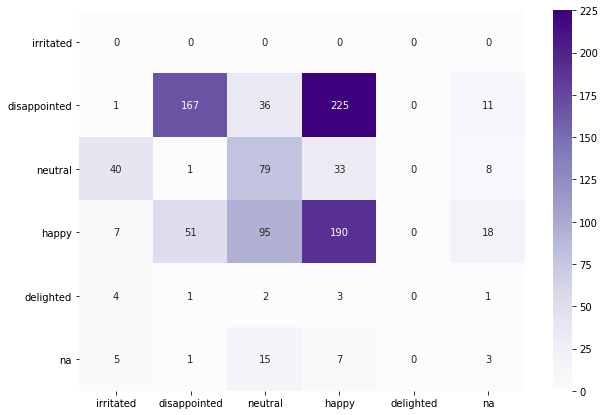

In [51]:
df_cm = pd.DataFrame(cm, index = ["irritated", "disappointed", "neutral", "happy", "delighted", "na"], columns = ["irritated", "disappointed", "neutral", "happy", "delighted", "na"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Purples', fmt='g')

From the above plot we can see that the most confused classes are 'joy' and 'love' which seems obivous as these two emotions are really close. We can say the same thing 'surprise' and 'anger' as well. So our model is doing pretty well.